# Plot model predictions for range expansions experiments

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from community import community
matplotlib.rc("figure", figsize=(10,5))
sns.set_theme(style="white", palette="deep")
sns.set_palette("deep")

from scipy.stats import t

If needed create output folder for figures:

In [2]:
!mkdir Figures/

mkdir: Figures/: File exists


## Load Data and set experimentally measured parameters

In [3]:

#load dictionary with fit parameters from file
with open('Processed-datafiles/fit_parameters.txt', 'r') as file:
    fit_pars = eval(file.read())

#load dictionary with growth rates from file    
with open('Experimental-datafiles/growth_rates.txt', 'r') as file:
    growth_rates = eval(file.read())
    
#we replace WT growth rate with average growth rate of dP and dT in presence of AA, as this is our actual control condition
growth_rates['WT'] = (growth_rates['dP'] + growth_rates['dT'])/2   
    
#load dataframe with preprocessing results
df_data = pd.read_csv('Processed-datafiles/community_data_mean.csv')  
  
#rename the data columns to match the prediction columns
columns_data={'Condition': 'community', 
              'Ratio': 'eq freq', 
              'rel_growth': 'relative growth', 
              'rel_range': 'relative range', 
              'dT_patch': 'range dT', 
              'dP_patch': 'range dP'}

df_data = df_data.rename(columns=columns_data)
df_data = df_data[df_data['community'] != 'AA'].reset_index(drop=True)
df_data['source'] = 'data'
df_data.drop('Width',axis=1,inplace=True)    

#rename community names to match paper
community_names = { 'A' : 'Ctr',
                    'B' : 'Pu',    #Pu: increased uptake of P
                    'C' : 'Tp',    #Tp: increased production of T
                    'D' : 'Tp Pu',  #Tp Pu: increased production of T and uptake of P
                    'E' : 'Pp',    #Pp: increased production of P
                    'F' : 'Pp Pu',  #Pp Pu: increased production of P and uptake of P
                    'G' : 'Tp Pp',  #Tp Pp: increased production of T and P
                    'H' : 'Tp Pp Pu' #Tp Pp Pu: increased production of T and P and uptake of P
                    }
        

# Rename entries in the "community" column
df_data['community'] = df_data['community'].replace(community_names)

df_data.head(n=8)

,community,eq freq,range dT,range dP,relative range,Ratio_std,rel_range_std,N_range,N_eq,relative growth,source
0,Ctr,0.240606,11.290686,52.947683,4.851652,0.016386,1.751668,5,6,0.083977,data
1,Pu,0.389557,9.237860,10.536059,1.197904,0.028002,0.727514,4,6,0.139551,data
2,Tp,0.557368,8.585891,18.913275,2.146284,0.022064,1.714038,5,6,-0.000413,data
3,Tp Pu,0.572360,22.793291,5.035559,0.214834,0.005222,0.081480,4,5,0.250800,data
4,Pp,0.161826,117.138821,227.426170,2.029934,0.048937,0.500054,5,6,0.675994,data
5,Pp Pu,0.300507,120.195380,176.149557,1.286966,0.038927,0.228003,5,6,0.718458,data
6,Tp Pp,0.334571,105.564071,116.726639,1.123821,0.075601,0.036914,5,6,0.711867,data
7,Tp Pp Pu,0.308416,112.732017,136.856448,1.197953,0.057034,0.107858,4,6,0.734203,data


---

## Predict community properties

In [4]:

  
#specify the parameters for the different communities
par_com_A = { #Ctr: original community
            'ndim': 3,
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': 1, 
            'c_prod_P': 1,
            'c_up_P': 1,
            'mu_WT': growth_rates['WT'],
            'mu_dP': growth_rates['dP'],
            'mu_dT': growth_rates['dT'],
            }

par_com_B = { #Pu: increased uptake of P
            'ndim': 3,
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': 1, 
            'c_prod_P': 1,
            'c_up_P': fit_pars['c_up_P'],
            'mu_WT': growth_rates['WT'],
            'mu_dP': growth_rates['dP_proUp'],
            'mu_dT': growth_rates['dT'],
            }

par_com_C = { #Tp: increased production of T
            'ndim': 3,
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': fit_pars['c_prod_T'], 
            'c_prod_P': 1,
            'c_up_P': 1,
            'mu_WT': growth_rates['WT'],
            'mu_dP': growth_rates['dP_trpOP'],
            'mu_dT': growth_rates['dT'],
            }

par_com_D = { # Tp Pu: increased production of T and uptake of P
            'ndim': 3,
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': fit_pars['c_prod_T'], 
            'c_prod_P': 1,
            'c_up_P': fit_pars['c_up_P'],
            'mu_WT': growth_rates['WT'],
            'mu_dP': growth_rates['dP_proUp'],
            'mu_dT': growth_rates['dT'],
            }

par_com_E = { #Pp: increased production of P
            'ndim': 3,
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': 1, 
            'c_prod_P': fit_pars['c_prod_P'],
            'c_up_P': 1,
            'mu_WT': growth_rates['WT'],
            'mu_dP': growth_rates['dP'],
            'mu_dT': growth_rates['dT_proOP'],
            }

par_com_F = { #Pp Pu: increased production of P and uptake of P
            'ndim': 3,
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': 1, 
            'c_prod_P': fit_pars['c_prod_P'],
            'c_up_P': fit_pars['c_up_P'],
            'mu_WT': growth_rates['WT'],
            'mu_dP': growth_rates['dP_proUp'], 
            'mu_dT': growth_rates['dT_proOP'],
            }


par_com_G = { #Tp Pp: increased production of T and P
            'ndim': 3,
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': fit_pars['c_prod_T'], 
            'c_prod_P': fit_pars['c_prod_P'],
            'c_up_P': 1,
            'mu_WT': growth_rates['WT'],
            'mu_dP': growth_rates['dP_trpOP'],
            'mu_dT': growth_rates['dT_proOP'],
            }

par_com_H = { #Tp Pp Pu: increased production of T and P and uptake of P
            'ndim': 3,
            'lPro': fit_pars['lPro'], 
            'lTrp': fit_pars['lTrp'], 
            'c_prod_T': fit_pars['c_up_P'], 
            'c_prod_P': fit_pars['c_prod_P'],
            'c_up_P': fit_pars['c_up_P'],
            'mu_WT': growth_rates['WT'],
            'mu_dP': growth_rates['dP_proUp'], 
            'mu_dT': growth_rates['dT_proOP'],
            }

#create a dictionary with the parameters for the different communities
par_coms = {'Ctr': par_com_A, #Ctr: original community
            'Pu': par_com_B, #Pu: increased uptake of P
            'Tp': par_com_C, #Tp: increased production of T
            'Tp Pu': par_com_D, #Tp Pu: increased production of T and uptake of P
            'Pp': par_com_E, #Pp: increased production of P
            'Pp Pu': par_com_F, #Pp Pu: increased production of P and uptake of P
            'Tp Pp': par_com_G, #Tp Pp: increased production of T and P
            'Tp Pp Pu': par_com_H} #Tp Pp Pu: increased production of T and P and uptake of P   

#run the community model for the different communities
communities = {key: community(**val) for key, val in par_coms.items()}

#extract the equilibrium properties of the different communities
df_pred = pd.DataFrame()
for key, val in communities.items():
    df_pred.loc[key, 'community'] = key
    df_pred.loc[key, 'source'] = 'model'
    df_pred.loc[key, 'eq freq'] = val.eq
    df_pred.loc[key, 'relative growth'] = val.rel_growth_wt
    df_pred.loc[key, 'relative range'] = val.rangeP/val.rangeT
    df_pred.loc[key, 'range dP'] = val.rangeP
    df_pred.loc[key, 'range dT'] = val.rangeT
    
df =  pd.concat([df_data, df_pred]).reset_index(drop=True)

#by default dtrpC frequency is shown, here we change to dProC frequency
df.rename(columns={'eq freq': '$\Delta$trpC frequency', 'relative range': 'Sector width ratio'}, inplace=True)
df['$\Delta$proC frequency'] = 1 - df['$\Delta$trpC frequency']

#add standard error estimate
df['$\Delta$proC frequency SE'] = df['Ratio_std'] / np.sqrt(df['N_eq'])
df['Sector width ratio SE'] = df['rel_range_std'] / np.sqrt(df['N_range'])

#add 95% CI
df['$\Delta$proC frequency SI'] = t.isf(0.025, df['N_eq']-1) * df['$\Delta$proC frequency SE']
df['Sector width ratio SI'] = t.isf(0.025, df['N_range']-1) * df['Sector width ratio SE']

#store the dataframe with the prediction and data
df.to_csv('Processed-datafiles/model_predictions.csv', index=False)

df.head(n=16)

,community,$\Delta$trpC frequency,range dT,range dP,Sector width ratio,Ratio_std,rel_range_std,N_range,N_eq,relative growth,source,$\Delta$proC frequency,$\Delta$proC frequency SE,Sector width ratio SE,$\Delta$proC frequency SI,Sector width ratio SI
0,Ctr,0.240606,11.290686,52.947683,4.851652,0.016386,1.751668,5.0,6.0,0.083977,data,0.759394,0.006690,0.783370,0.017196,2.174984
1,Pu,0.389557,9.237860,10.536059,1.197904,0.028002,0.727514,4.0,6.0,0.139551,data,0.610443,0.011432,0.363757,0.029387,1.157637
2,Tp,0.557368,8.585891,18.913275,2.146284,0.022064,1.714038,5.0,6.0,-0.000413,data,0.442632,0.009008,0.766541,0.023155,2.128260
3,Tp Pu,0.572360,22.793291,5.035559,0.214834,0.005222,0.081480,4.0,5.0,0.250800,data,0.427640,0.002335,0.040740,0.006484,0.129652
4,Pp,0.161826,117.138821,227.426170,2.029934,0.048937,0.500054,5.0,6.0,0.675994,data,0.838174,0.019978,0.223631,0.051356,0.620899
5,Pp Pu,0.300507,120.195380,176.149557,1.286966,0.038927,0.228003,5.0,6.0,0.718458,data,0.699493,0.015892,0.101966,0.040852,0.283103
6,Tp Pp,0.334571,105.564071,116.726639,1.123821,0.075601,0.036914,5.0,6.0,0.711867,data,0.665429,0.030864,0.016508,0.079338,0.045835
7,Tp Pp Pu,0.308416,112.732017,136.856448,1.197953,0.057034,0.107858,4.0,6.0,0.734203,data,0.691584,0.023284,0.053929,0.059853,0.171626
8,Ctr,0.240779,2.803935,11.858379,4.229191,NaN,NaN,NaN,NaN,0.084037,model,0.759221,NaN,NaN,NaN,NaN
9,Pu,0.357465,2.803935,3.357567,1.197448,NaN,NaN,NaN,NaN,0.070687,model,0.642535,NaN,NaN,NaN,NaN


## Plot comparison of model predictions and data

### Compare prediction to observation for absolute values of sector width ratio and EQ frequency

In [5]:
def make_bar_plot(df, xname, yname, errname, huename, ax):
    """
    Create a bar plot using the provided data.

    Parameters:
    - df: DataFrame containing the data.
    - xname: Name of the column in df representing the x-axis values.
    - yname: Name of the column in df representing the y-axis values.
    - errname: Name of the column in df representing the error values.
    - huename: Name of the column in df representing the hue values.
    - ax: Axes object to plot the bar plot on.

    Returns:
    None
    """
    hues = df[huename].unique()
    xvals = df[xname].unique()

    x = np.arange(len(xvals))  # the label locations
    width = 0.4  # the width of the bars
    
    offsetfactor = width / 2 if len(hues) == 2 else 0

    for idx, hue in enumerate(hues):
        offset = - offsetfactor if idx == 0 else offsetfactor
        y = df[df[huename] == hue][yname].to_numpy()
        err = df[df[huename] == hue][errname].to_numpy()
        ax.bar(x + offset, y, width, label=hue, yerr=err, error_kw=dict(ecolor='black', lw=1, capsize=2, capthick=1))

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xticks(x)
    ax.set_xticklabels(xvals)

    ax.set_ylabel(yname)
    ax.set_xlabel(xname)
    return None

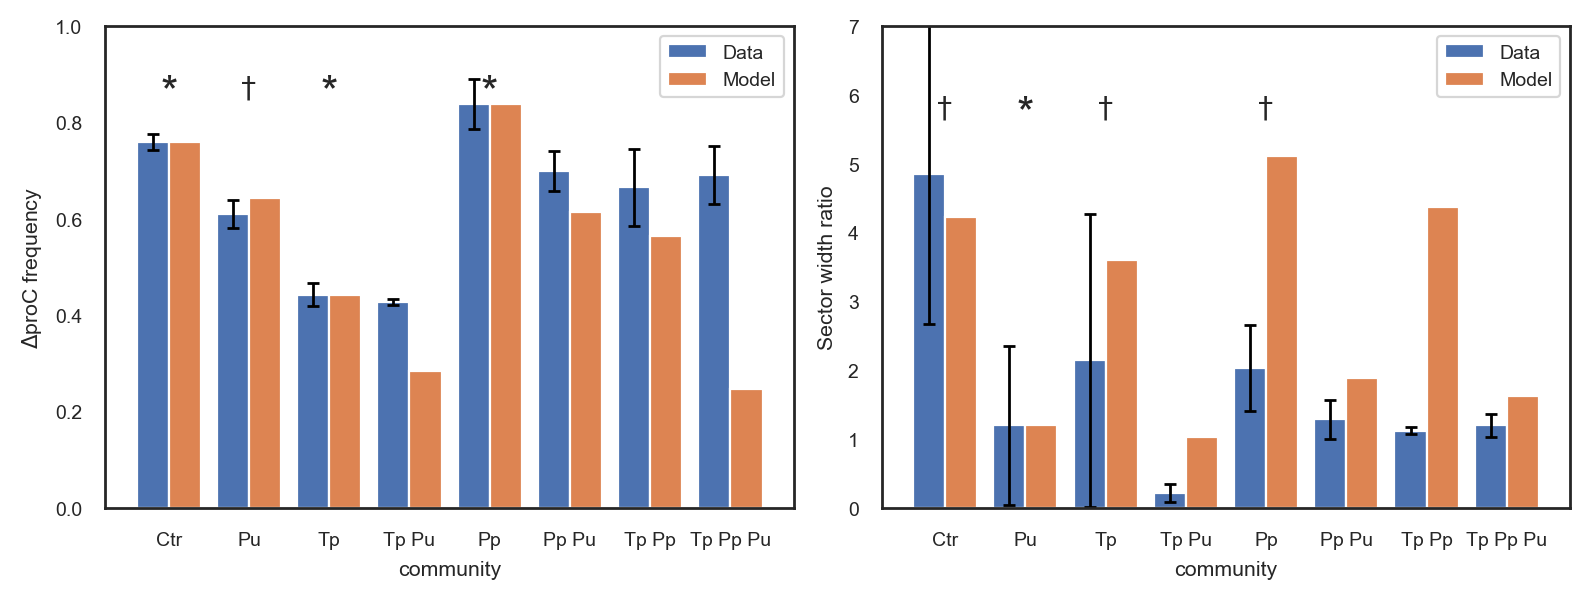

In [40]:
# Apply seaborn style
sns.set_theme(style="white", palette="deep")
sns.set_palette("deep")

# Set the context with smaller font scale
sns.set_context("paper", font_scale=0.8)

#plot the prediction and data for EQ freq and relative range
fig, axs = plt.subplots(1,2,figsize=(8,3))
make_bar_plot(df, "community", "$\Delta$proC frequency", "$\Delta$proC frequency SI", "source", axs[0])
make_bar_plot(df, "community", "Sector width ratio", "Sector width ratio SI", "source", axs[1])
fig.tight_layout()

# Set max y-axis value for each subplot
axs[0].set_ylim(top=1)  # Set max y-axis value for the first subplot
axs[1].set_ylim(top=7)  # Set max y-axis value for the third subplot

axs[0].legend(['Data', 'Model'], loc='upper right')
axs[1].legend(['Data', 'Model'], loc='upper right')

# Add stars above communities that where fitted to the data
y_star_eq = 0.02
y_star_range = 0.3

ssize = 16
dsize = 10
axs[0].annotate('*', xy=(0, 0.9), fontsize=ssize, ha='center', va='top')
axs[0].annotate('†', xy=(1, 0.9), fontsize=dsize, ha='center', va='top')
axs[0].annotate('*', xy=(2, 0.9), fontsize=ssize, ha='center', va='top')
axs[0].annotate('*', xy=(4, 0.9), fontsize=ssize, ha='center', va='top')


axs[1].annotate('†', xy=(0, 6), fontsize=dsize, ha='center', va='top')
axs[1].annotate('*', xy=(1, 6), fontsize=ssize, ha='center', va='top')
axs[1].annotate('†', xy=(2, 6), fontsize=dsize, ha='center', va='top')
axs[1].annotate('†', xy=(4, 6), fontsize=dsize, ha='center', va='top')

fig.savefig(f"Figures/model_predictions.pdf")

### Calculate change in sector width ratio and EQ frequency and prediction error

In [7]:
#calculate change in sector size and equilibrium frequencies relative to the control community, for data
df_data = df[df['source']=='data'].copy()
ctr_row = df_data[df_data['community'] == 'Ctr']

# Select numeric columns
numeric_columns = df_data.select_dtypes(include='number').columns
rename_dict = {col : 'Change in ' + col for col in numeric_columns}

#calc SE for the change, change = (X_i_data - X_ctr_data) so SE = sqrt(SD_i_data^2 + SD_ctr_data^2) / sqrt(N)
se_ratio = np.sqrt(df_data["Ratio_std"]**2 + ctr_row["Ratio_std"].values**2) / np.sqrt(df_data["N_eq"])
se_range = np.sqrt(df_data["rel_range_std"]**2 + ctr_row["rel_range_std"].values**2) / np.sqrt(df_data["N_range"])

# Subtract ctr_row values from other rows in numeric columns
df_data[numeric_columns] = df_data[numeric_columns].sub(ctr_row[numeric_columns].values[0])
df_data.rename(columns=rename_dict, inplace=True)
df_data.drop(["Change in N_eq","Change in N_range","Change in Ratio_std","Change in rel_range_std"], axis=1, inplace=True)
df_data["N_eq"] = df[df['source']=='data']["N_eq"] #add N column
df_data["N_range"] = df[df['source']=='data']["N_range"] #add N column
df_data = df_data[df_data['community'] != 'Ctr']

df_data['Change in $\Delta$proC frequency SE'] = se_ratio
df_data['Change in Sector width ratio SE'] = se_range

#add 95% CI
df_data['Change in $\Delta$proC frequency SI'] = t.isf(0.025, df_data['N_eq']-1) * df_data['Change in $\Delta$proC frequency SE']
df_data['Change in Sector width ratio SI'] = t.isf(0.025, df_data['N_range']-1) * df_data['Change in Sector width ratio SE']


#calculate change in sector size and equilibrium frequencies relative to the control community, for model
df_pred = df[df['source']=='model'].copy()
ctr_row = df_pred[df_pred['community'] == 'Ctr']

# Select numeric columns
numeric_columns = df_pred.select_dtypes(include='number').columns
rename_dict = {col : 'Change in ' + col for col in numeric_columns}

# Subtract ctr_row values from other rows in numeric columns
df_pred[numeric_columns] = df_pred[numeric_columns].sub(ctr_row[numeric_columns].values[0])
df_pred.rename(columns=rename_dict, inplace=True)
df_pred.drop(["Change in N_eq","Change in N_range","Change in Ratio_std","Change in rel_range_std"], axis=1, inplace=True)
df_pred = df_pred[df_pred['community'] != 'Ctr']

#combine the data and model predictions
df_rel = pd.concat([df_data, df_pred]).reset_index(drop=True)

#calculate the error between the data and model predictions
df_rel_data = df_rel[df_rel['source']=='data'].copy().reset_index(drop=True) #data
df_rel_model = df_rel[df_rel['source']=='model'].copy().reset_index(drop=True) #model

#error = data - model
df_error = pd.DataFrame()
df_error['community'] = df_rel_data['community']
error_cols = {"Prediction error strain frequency": 'Change in $\Delta$proC frequency', 
              "Prediction error sector width ratio" :'Change in Sector width ratio'}

for key, val in error_cols.items():
    df_error[key] = df_rel_data[val].sub(df_rel_model[val].values)
df_error['source'] = 'error'

#add the SE for the error,  error = (change_data - change_model) = ((X_i_data - X_ctr_data) - (X_i_model - X_ctr_model)) so SE = sqrt(SD_i_data^2 + SD_ctr_data^2) / sqrt(N) = SE of change
df_error["Error strain frequency SE"] = df_data["Change in $\Delta$proC frequency SE"].reset_index(drop=True)
df_error["Error sector width ratio SE"] = df_data["Change in Sector width ratio SE"].reset_index(drop=True)

#add 95% CI
df_error["Error strain frequency SI"] = df_data["Change in $\Delta$proC frequency SI"].reset_index(drop=True)
df_error["Error sector width ratio SI"] = df_data["Change in Sector width ratio SI"].reset_index(drop=True)


### Plot full comparison model and dat

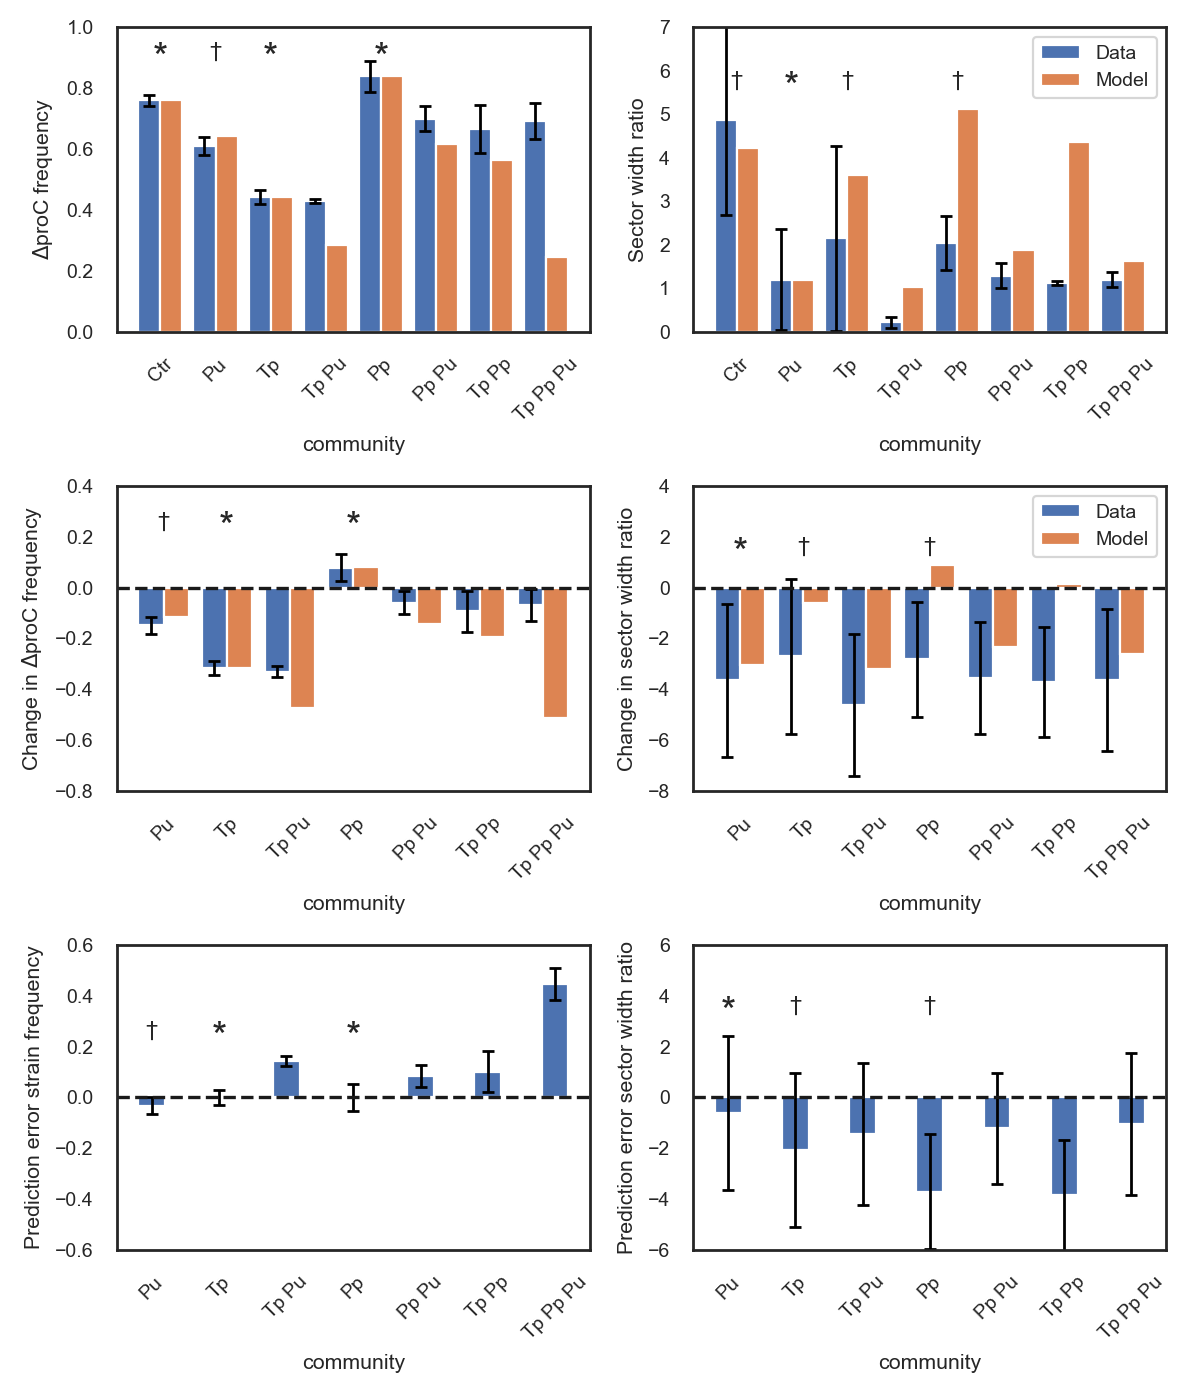

In [39]:
#plot the prediction and data for EQ freq and relative range
fig, axs = plt.subplots(3,2,figsize=(6,7))
make_bar_plot(df, "community", "$\Delta$proC frequency", "$\Delta$proC frequency SI", "source", axs[0][0])
make_bar_plot(df, "community", "Sector width ratio", "Sector width ratio SI", "source", axs[0][1])

# Set max y-axis value for each subplot
axs[0][0].set_ylim(top=1)  # Set max y-axis value for the first subplot
axs[0][1].set_ylim(top=7)  # Set max y-axis value for the third subplot

# Add stars above communities that where fitted to the data
y_star_eq = 0.02
y_star_range = 0.3

ssize = 14
dsize = 8
axs[0][0].annotate('*', xy=(0, 0.95), fontsize=ssize, ha='center', va='top')
axs[0][0].annotate('†', xy=(1, 0.95), fontsize=dsize, ha='center', va='top')
axs[0][0].annotate('*', xy=(2, 0.95), fontsize=ssize, ha='center', va='top')
axs[0][0].annotate('*', xy=(4, 0.95), fontsize=ssize, ha='center', va='top')

axs[0][1].annotate('†', xy=(0, 6), fontsize=dsize, ha='center', va='top')
axs[0][1].annotate('*', xy=(1, 6), fontsize=ssize, ha='center', va='top')
axs[0][1].annotate('†', xy=(2, 6), fontsize=dsize, ha='center', va='top')
axs[0][1].annotate('†', xy=(4, 6), fontsize=dsize, ha='center', va='top')

axs[0][1].legend(['Data', 'Model'], loc='upper right')


#plot the prediction and data for EQ freq and relative range
df_rel.rename(columns={'Change in Sector width ratio': 'Change in sector width ratio'}, inplace=True)
make_bar_plot(df_rel, "community", "Change in $\Delta$proC frequency", "Change in $\Delta$proC frequency SI", "source", axs[1][0])
make_bar_plot(df_rel, "community", "Change in sector width ratio", "Change in Sector width ratio SI", "source", axs[1][1])

# Add stars above communities that where fitted to the data
axs[1][0].annotate('*', xy=(1, 0.3), fontsize=ssize, ha='center', va='top')
axs[1][0].annotate('*', xy=(3, 0.3), fontsize=ssize, ha='center', va='top')
axs[1][0].annotate('†', xy=(0, 0.3), fontsize=dsize, ha='center', va='top')

axs[1][1].annotate('†', xy=(1, 2), fontsize=dsize, ha='center', va='top')
axs[1][1].annotate('†', xy=(3, 2), fontsize=dsize, ha='center', va='top')
axs[1][1].annotate('*', xy=(0, 2), fontsize=ssize, ha='center', va='top')


# Set max y-axis value for each subplot
axs[1][0].set_ylim((-0.8,0.4))  # Set max y-axis value for the first subplot
axs[1][1].set_ylim((-8,4))  # Set max y-axis value for the third subplot

axs[1][1].legend(['Data', 'Model'], loc='upper right')


#add dotted vertical reference line
axs[1][0].axhline(y=0, color='k', linestyle='--')
axs[1][1].axhline(y=0, color='k', linestyle='--')


#plot the prediction and data for EQ freq and relative range
make_bar_plot(df_error, "community", "Prediction error strain frequency", "Error strain frequency SI", "source", axs[2][0])
make_bar_plot(df_error, "community", "Prediction error sector width ratio", "Error sector width ratio SI", "source", axs[2][1])

#Add stars above communities that where fitted to the data
y_star_eq = 0.3
y_star_range = 4

axs[2][0].annotate('*', xy=(1, y_star_eq), fontsize=ssize, ha='center', va='top')
axs[2][0].annotate('*', xy=(3, y_star_eq), fontsize=ssize, ha='center', va='top')
axs[2][0].annotate('†', xy=(0, y_star_eq), fontsize=dsize, ha='center', va='top')

axs[2][1].annotate('†', xy=(1, y_star_range), fontsize=dsize, ha='center', va='top')
axs[2][1].annotate('†', xy=(3, y_star_range), fontsize=dsize, ha='center', va='top')
axs[2][1].annotate('*', xy=(0, y_star_range), fontsize=ssize, ha='center', va='top')


#add dotted vertical reference line
axs[2][0].axhline(y=0, color='k', linestyle='--')
axs[2][1].axhline(y=0, color='k', linestyle='--')


axs[2][0].set_ylim((-0.6,0.6));  
axs[2][1].set_ylim((-6,6));  


for ax in axs.flatten():
    ax.tick_params(axis='x', labelrotation=45)

fig.tight_layout()


fig.savefig(f"Figures/model_predictions_relative_change_and_error.pdf")
fig.savefig(f"Figures/model_predictions_relative_change_and_error.png")

### Show absolute sector size

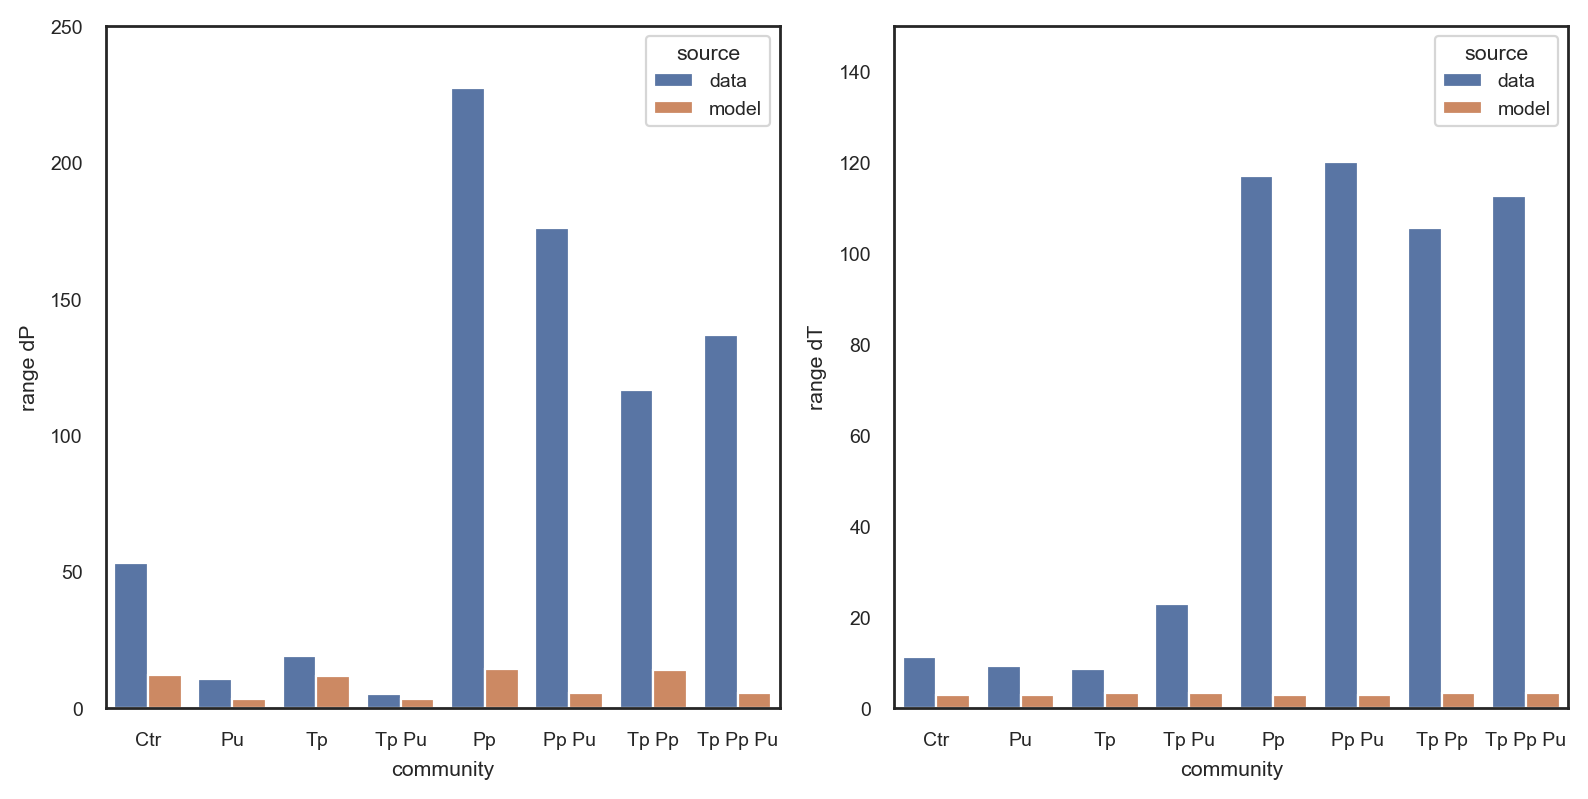

In [9]:
#plot the prediction and data for absolute range dP and range dT
fig, axs = plt.subplots(1,2,figsize=(8,4))
sns.barplot(df, x="community", y="range dP", hue="source", ax=axs[0])
sns.barplot(df, x="community", y="range dT", hue="source", ax=axs[1])
fig.tight_layout()

# Set max y-axis value for each subplot
axs[0].set_ylim(top=250)  # Set max y-axis value for the first subplot
axs[1].set_ylim(top=150)  # Set max y-axis value for the third subplot

#add dotted vertical reference line
fig.savefig(f"Figures/model_predictions_abs_range.pdf")

## Report Model Predictions

In [10]:
df.head(n=16)

,community,$\Delta$trpC frequency,range dT,range dP,Sector width ratio,Ratio_std,rel_range_std,N_range,N_eq,relative growth,source,$\Delta$proC frequency,$\Delta$proC frequency SE,Sector width ratio SE,$\Delta$proC frequency SI,Sector width ratio SI
0,Ctr,0.240606,11.290686,52.947683,4.851652,0.016386,1.751668,5.0,6.0,0.083977,data,0.759394,0.006690,0.783370,0.017196,2.174984
1,Pu,0.389557,9.237860,10.536059,1.197904,0.028002,0.727514,4.0,6.0,0.139551,data,0.610443,0.011432,0.363757,0.029387,1.157637
2,Tp,0.557368,8.585891,18.913275,2.146284,0.022064,1.714038,5.0,6.0,-0.000413,data,0.442632,0.009008,0.766541,0.023155,2.128260
3,Tp Pu,0.572360,22.793291,5.035559,0.214834,0.005222,0.081480,4.0,5.0,0.250800,data,0.427640,0.002335,0.040740,0.006484,0.129652
4,Pp,0.161826,117.138821,227.426170,2.029934,0.048937,0.500054,5.0,6.0,0.675994,data,0.838174,0.019978,0.223631,0.051356,0.620899
5,Pp Pu,0.300507,120.195380,176.149557,1.286966,0.038927,0.228003,5.0,6.0,0.718458,data,0.699493,0.015892,0.101966,0.040852,0.283103
6,Tp Pp,0.334571,105.564071,116.726639,1.123821,0.075601,0.036914,5.0,6.0,0.711867,data,0.665429,0.030864,0.016508,0.079338,0.045835
7,Tp Pp Pu,0.308416,112.732017,136.856448,1.197953,0.057034,0.107858,4.0,6.0,0.734203,data,0.691584,0.023284,0.053929,0.059853,0.171626
8,Ctr,0.240779,2.803935,11.858379,4.229191,NaN,NaN,NaN,NaN,0.084037,model,0.759221,NaN,NaN,NaN,NaN
9,Pu,0.357465,2.803935,3.357567,1.197448,NaN,NaN,NaN,NaN,0.070687,model,0.642535,NaN,NaN,NaN,NaN


---

## Plot growth profiles for all the communities

In [11]:
def plot_growth_profile(community):
    ''' Plot growth profiles of the community
    
    Parameters:
    community: community object
    
    Returns:
    fig: figure object
    
    '''

    #set colors
    yellow = np.array([246,219,147])/255
    blue = np.array([42,86,152])/255
    
    #calculate growth profiles
    x_vec = np.linspace(0,60,1000)
    community.calc_growth_profiles(x_vec)
    #community.calc_growth_profiles_sectors()
    
    #normalize to WT growth rate
    muWT = community.mu0 * 3600
    
    #plot growth profiles
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    ax.plot(community.x_T, community.mu_profile_T/muWT, color=yellow, label='dT')
    ax.plot(community.x_P, community.mu_profile_P/muWT, color=blue, label='dP')
    
    # ax.plot(community.x_sector_T, community.mu_profile_sector_T/muWT, color=yellow, label='dT sect', linestyle='--')
    # ax.plot(community.x_sector_P, community.mu_profile_sector_P/muWT, color=blue, label='dP sect', linestyle='--')    
    
    ax.set_xlabel('Position (um)')
    ax.set_ylabel('Growth rate relative to WT')
    ax.set_ylim(0,1)
    
    #add reference lines
    plt.axvline(x=0, color='k', linestyle='-')
    plt.axvline(x=community.rangeP, color=blue, linestyle=':')
    plt.axvline(x=-community.rangeT, color=yellow, linestyle=':')

    return fig

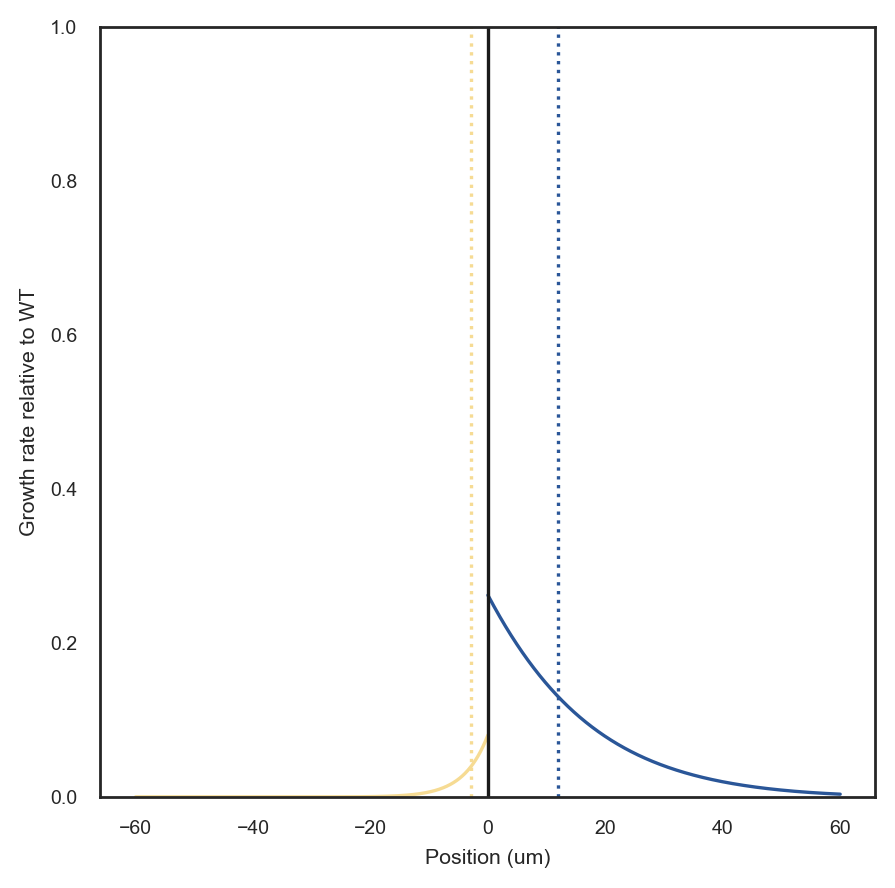

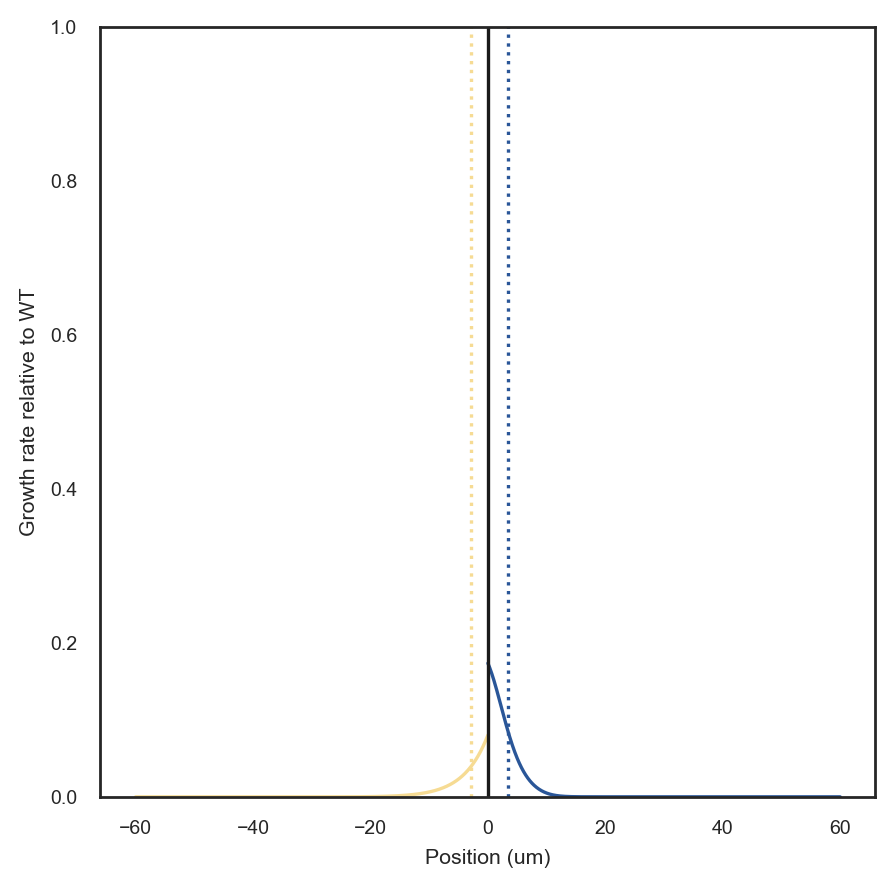

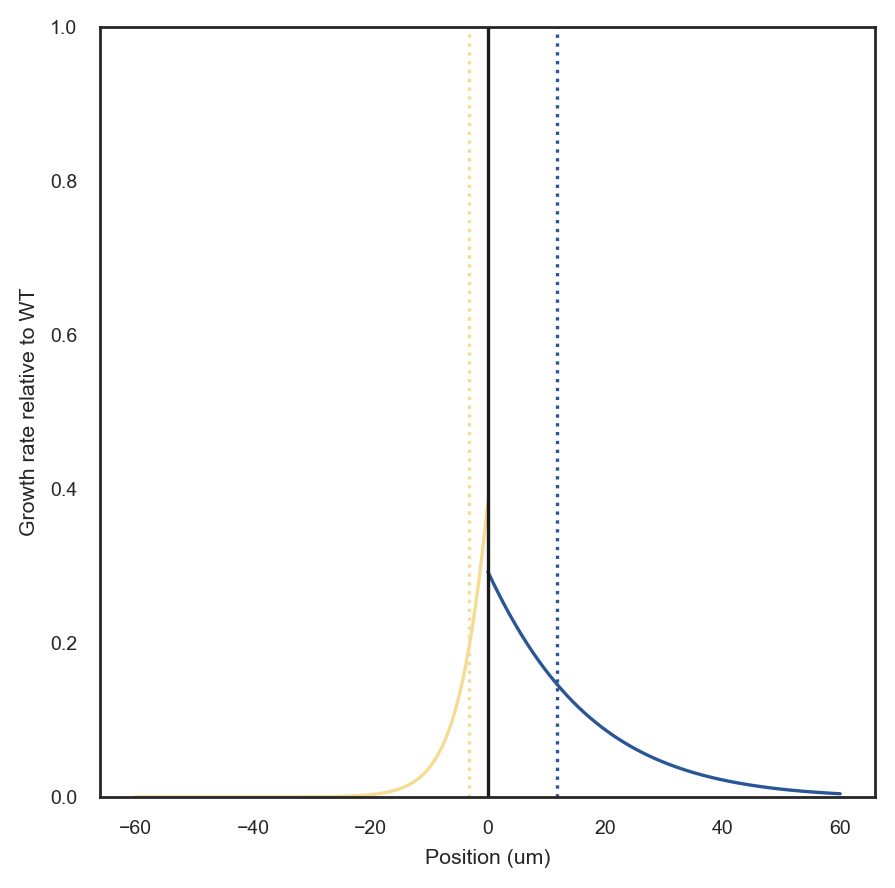

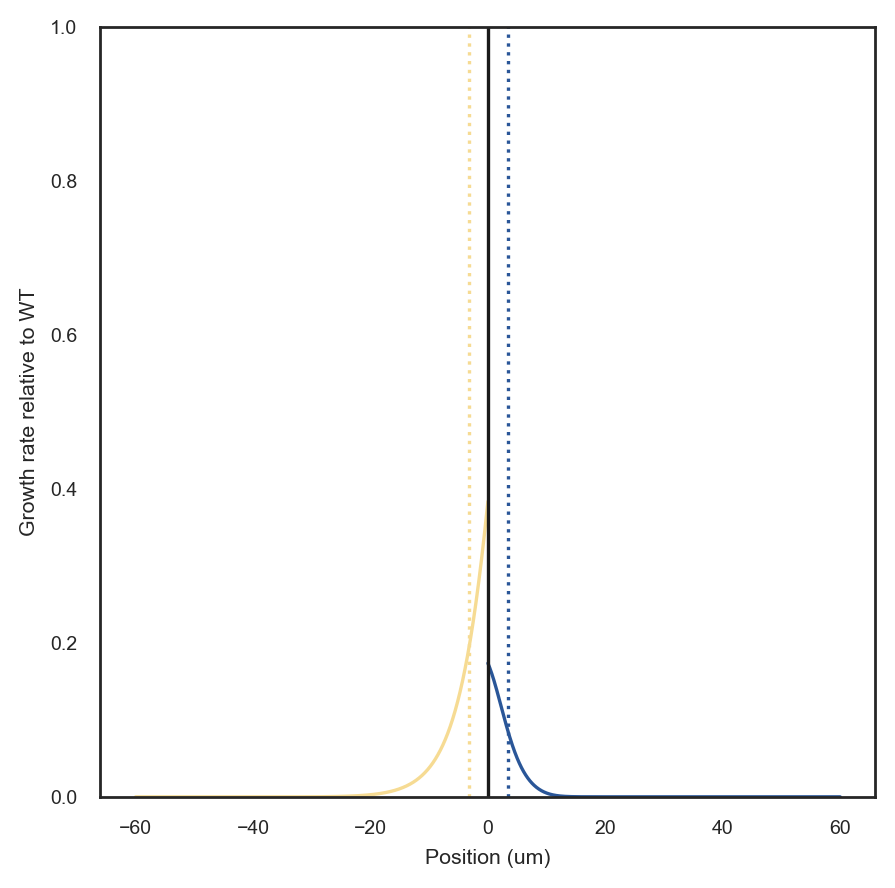

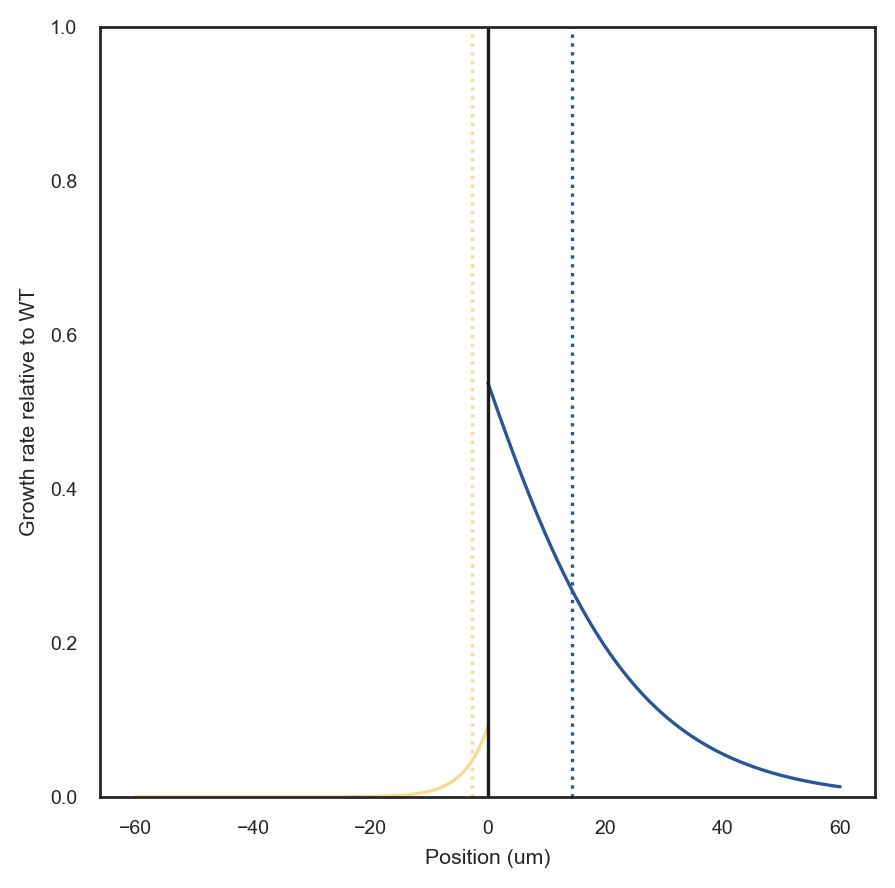

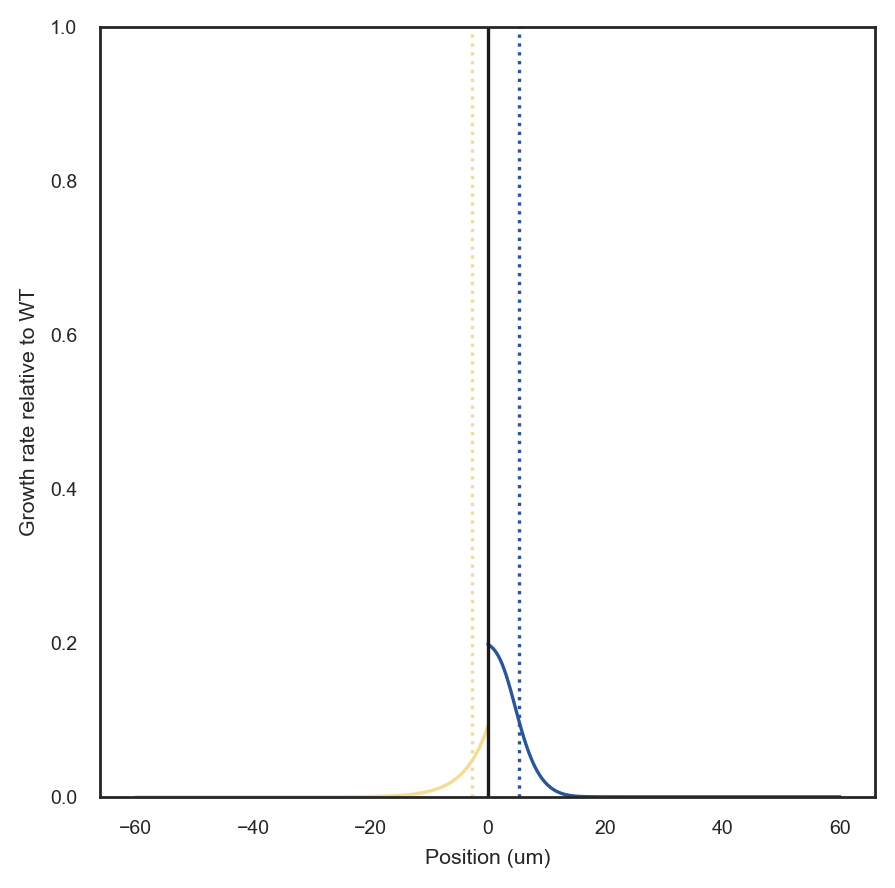

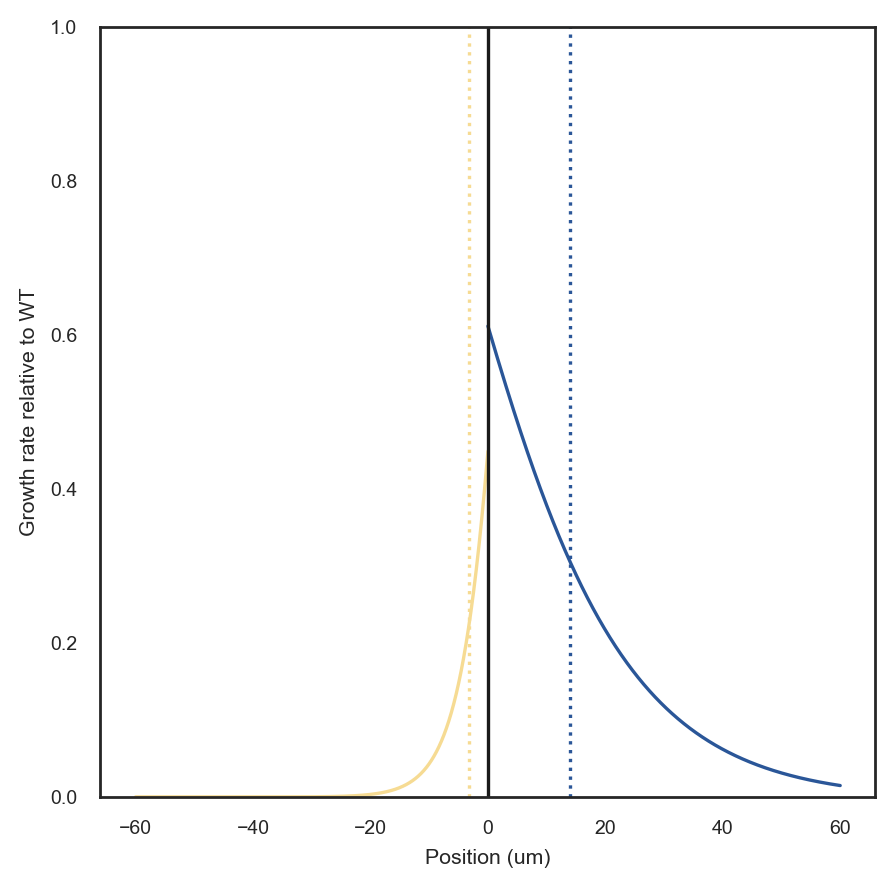

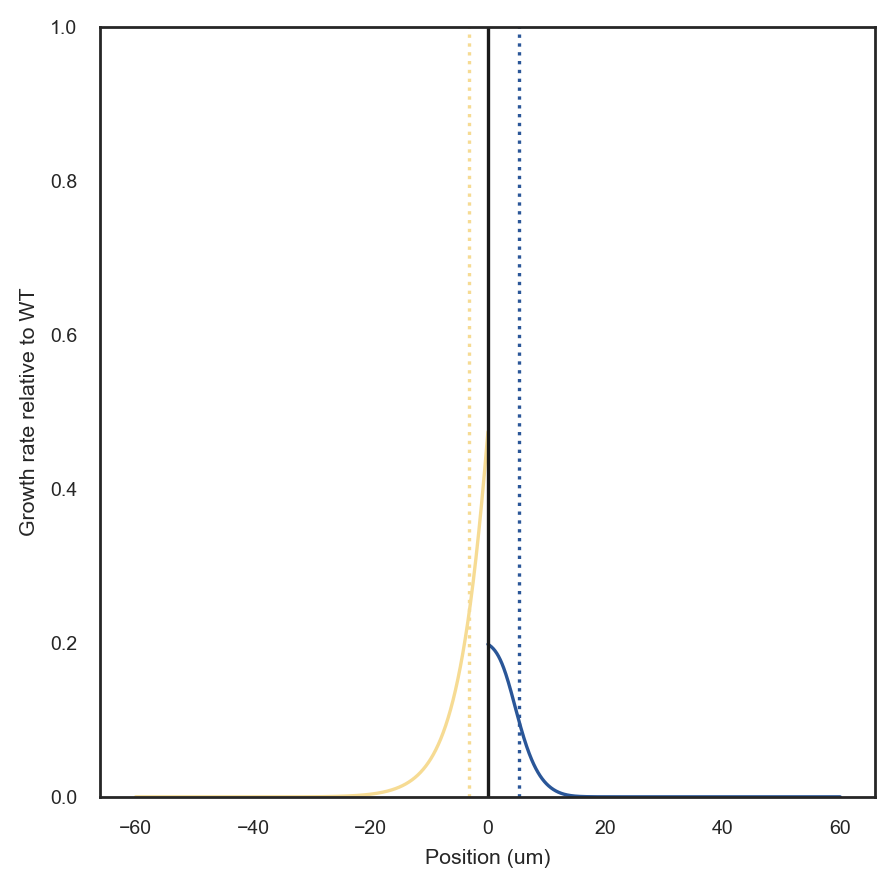

In [12]:
for key, val in communities.items():
    plot_growth_profile(val).savefig(f"Figures/growth_profile_community{key}.pdf")

---

## Plot parameter dependence of fitted parameters

In [13]:
def plot_parameter_sensitivity(df_data,x,x_fit,community_fit, community_name, xlabel, xticks, ylim_range=5):
    #add reference lines
    fig,ax = plt.subplots(2,1,figsize=(5,4))

    eq_data = df_data[df_data['community']==community_name]['$\Delta$trpC frequency'].values[0]
    rel_range_data = df_data[df_data['community']==community_name]['Sector width ratio'].values[0]
    ax[0].axhline(y=rel_range_data, color='k', linestyle='--', linewidth=0.5)
    ax[1].axhline(y=eq_data, color='k', linestyle='--', linewidth=0.5)

    ax[0].axvline(x=x_fit, color='k', linestyle='--', linewidth=0.5)
    ax[1].axvline(x=x_fit, color='k', linestyle='--', linewidth=0.5)

    rel_range = community_fit.rangeP/community_fit.rangeT

    ax[0].plot(x, rel_range)
    ax[1].plot(x, community_fit.eq)

    ax[1].set_xlabel(xlabel)
    ax[0].set_ylabel('Sector width ratio')
    ax[1].set_ylabel('$\Delta$trpC frequency')


    #set x-ticks
    ax[0].set_xlim(left=1, right=xticks.max())
    ax[1].set_xlim(left=1, right=xticks.max())
    ax[0].set_xticks(xticks)
    ax[1].set_xticks(xticks)
    ax[1].set_yticks([0,0.25,0.5,0.75,1])
    ax[0].set_xticklabels('')

    ax[0].set_ylim(0,ylim_range)
    ax[1].set_ylim(0,1)

    plt.tight_layout()
    return fig

### Community B

We show how increase in pro uptake caused by putP over expression affects relative sector size (range dP / range dT) in community B (dP-pEP17-putP + dT)

In [14]:
df_data = df[df['source']=='data'].copy()
df_data.head(n=9)


,community,$\Delta$trpC frequency,range dT,range dP,Sector width ratio,Ratio_std,rel_range_std,N_range,N_eq,relative growth,source,$\Delta$proC frequency,$\Delta$proC frequency SE,Sector width ratio SE,$\Delta$proC frequency SI,Sector width ratio SI
0,Ctr,0.240606,11.290686,52.947683,4.851652,0.016386,1.751668,5.0,6.0,0.083977,data,0.759394,0.006690,0.783370,0.017196,2.174984
1,Pu,0.389557,9.237860,10.536059,1.197904,0.028002,0.727514,4.0,6.0,0.139551,data,0.610443,0.011432,0.363757,0.029387,1.157637
2,Tp,0.557368,8.585891,18.913275,2.146284,0.022064,1.714038,5.0,6.0,-0.000413,data,0.442632,0.009008,0.766541,0.023155,2.128260
3,Tp Pu,0.572360,22.793291,5.035559,0.214834,0.005222,0.081480,4.0,5.0,0.250800,data,0.427640,0.002335,0.040740,0.006484,0.129652
4,Pp,0.161826,117.138821,227.426170,2.029934,0.048937,0.500054,5.0,6.0,0.675994,data,0.838174,0.019978,0.223631,0.051356,0.620899
5,Pp Pu,0.300507,120.195380,176.149557,1.286966,0.038927,0.228003,5.0,6.0,0.718458,data,0.699493,0.015892,0.101966,0.040852,0.283103
6,Tp Pp,0.334571,105.564071,116.726639,1.123821,0.075601,0.036914,5.0,6.0,0.711867,data,0.665429,0.030864,0.016508,0.079338,0.045835
7,Tp Pp Pu,0.308416,112.732017,136.856448,1.197953,0.057034,0.107858,4.0,6.0,0.734203,data,0.691584,0.023284,0.053929,0.059853,0.171626


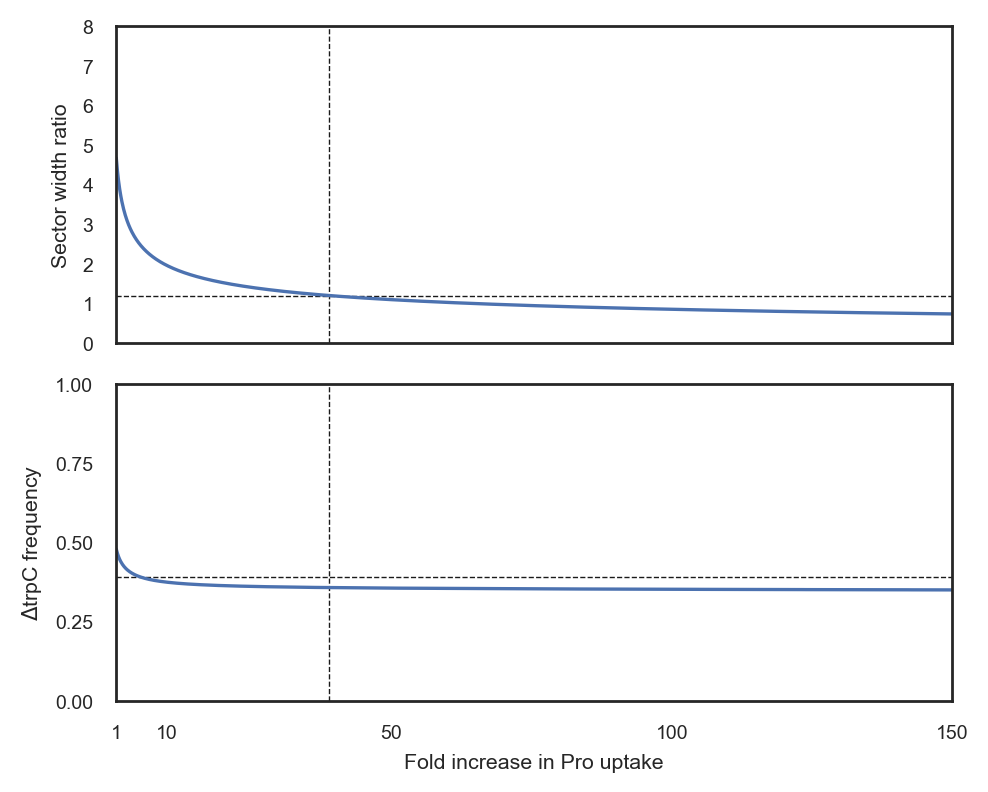

In [15]:

c_up_P = np.arange(1,150.1,0.1)
xticks = np.array([1,10,50,100,150])

par_com_B_var = par_com_B.copy()
par_com_B_var['c_up_P'] = c_up_P

com_B = community(**par_com_B_var)
x_fit = fit_pars['c_up_P']

fig = plot_parameter_sensitivity(df_data,c_up_P, x_fit, com_B, 'Pu', 'Fold increase in Pro uptake', xticks, ylim_range=8)
fig.savefig(f"Figures/parameter_sensitivity_communityB_proUptake.pdf")

### Community C

We fit increase in trp leakage caused by trpR deletion by fitting model to equilibrium fraction of community C (dT + dP-trpR)

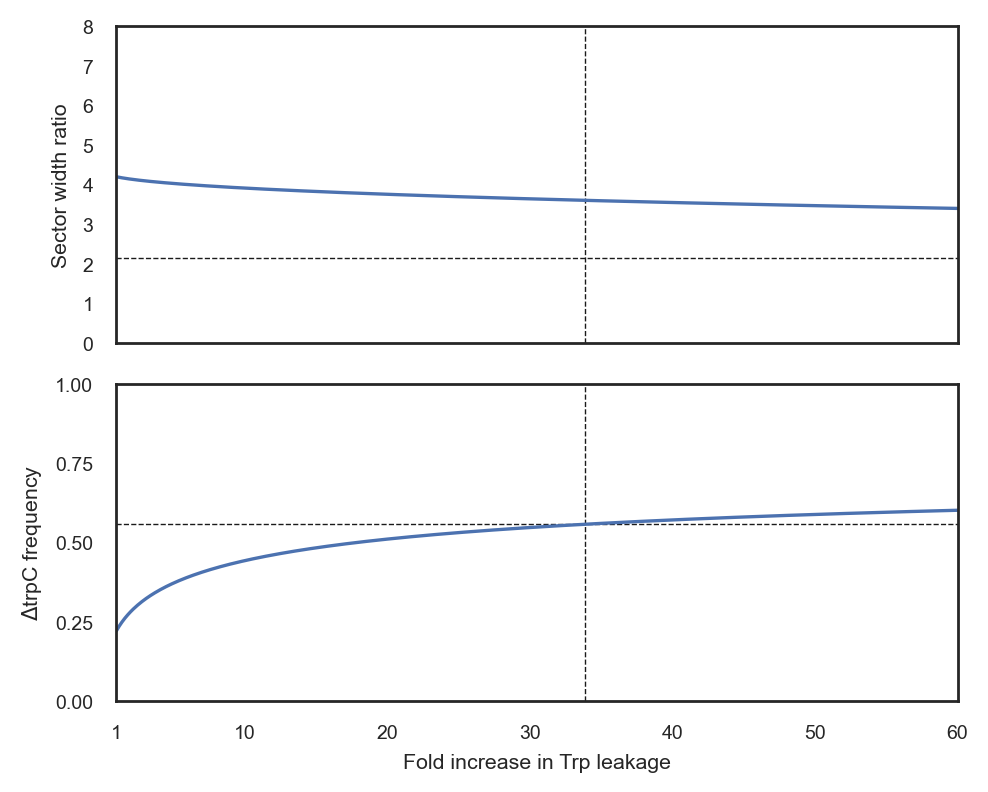

In [16]:
c_prod_T = np.arange(1,60.1,0.1)
xticks = np.array([1,10,20,30, 40, 50, 60])

par_com_C_var = par_com_C.copy()
par_com_C_var['c_prod_T'] = c_prod_T

com_C = community(**par_com_C_var)
x_fit = fit_pars['c_prod_T']

fig = plot_parameter_sensitivity(df_data,c_prod_T, x_fit,com_C, 'Tp', 'Fold increase in Trp leakage', xticks, ylim_range=8)
fig.savefig(f"Figures/parameter_sensitivity_communityC_trpLeakage.pdf")


### Community E

We fit increase in pro leakage caused by proB74 mutation by fitting model to equilibrium fraction of community E (dT-proB74 + dP)

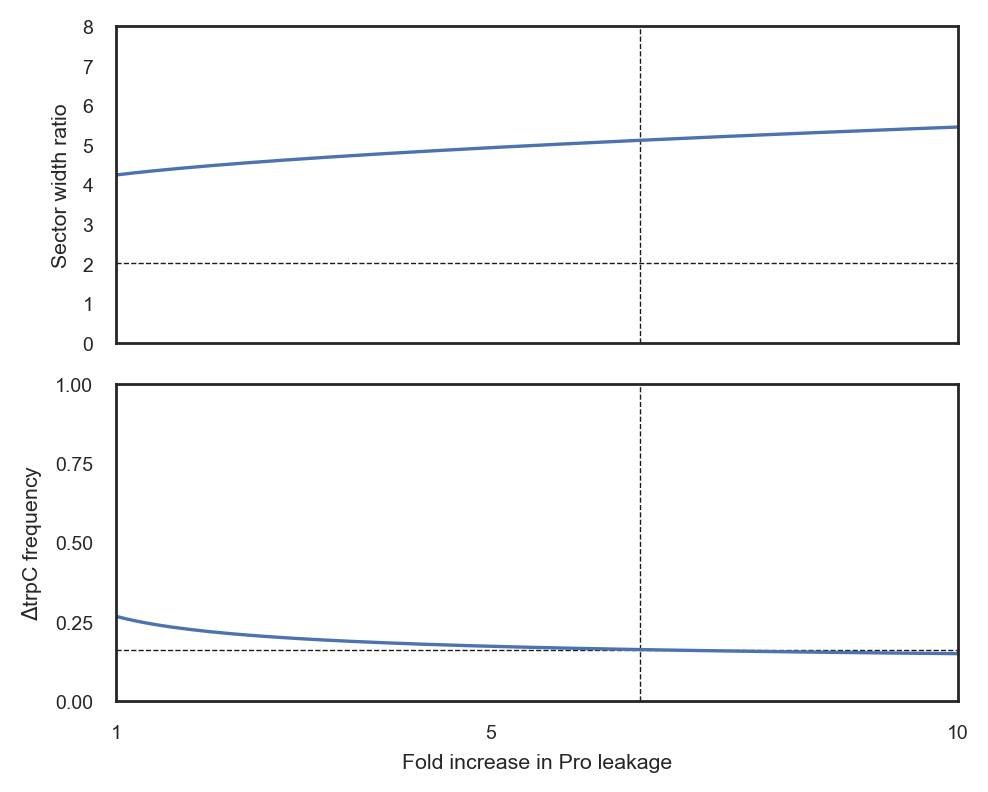

In [17]:
c_prod_P = np.arange(1,60.1,0.1)
xticks = np.array([1,5,10])

par_com_E_var = par_com_E.copy()
par_com_E_var['c_prod_P'] = c_prod_P

com_E = community(**par_com_E_var)
x_fit = fit_pars['c_prod_P']

fig = plot_parameter_sensitivity(df_data,c_prod_P, x_fit,com_E, 'Pp', 'Fold increase in Pro leakage', xticks, ylim_range=8)
fig.savefig(f"Figures/parameter_sensitivity_communityE_proLeakage.pdf")